這邊我會假設你已經看過[Darknet-53_structure](https://github.com/shaoeChen/deeplearning/blob/master/tf2/Arch_YOLOv3_1_Darknet-53_structure.ipynb)、[YOLOv3_structure](https://github.com/shaoeChen/deeplearning/blob/master/tf2/Arch_YOLOv3_2_YOLOv3_structure.ipynb)以及[Arch_YOLOv3_3_loss_function](https://github.com/shaoeChen/deeplearning/blob/master/tf2/Arch_YOLOv3_3_loss_function.ipynb)的說明，而且你也已經完全明白上述三篇文章的說明。

<img src="https://hackmd.io/_uploads/rJ6UBYVli.png" width="75%" />

下面先給出眾多的參考資料，瞭解一個架構不容易，參考的自然也多了，正確的寫出引用、參照是學習過程中的必要：

* [YOLO: Real-Time Object Detection](https://pjreddie.com/darknet/yolo/)
* [pjreddie/darknet](https://github.com/pjreddie/darknet)
* [YOLOv3_論文翻譯連結](https://hackmd.io/@shaoeChen/SyjI6W2zB/https%3A%2F%2Fhackmd.io%2F%40shaoeChen%2FryHg904h9)
* [YOLOv3深度解析](https://blog.csdn.net/leviopku/article/details/82660381)
* [qqwweee/keras-yolo3](https://github.com/qqwweee/keras-yolo3)
* [YunYang1994/tensorflow-yolov3](https://github.com/YunYang1994/tensorflow-yolov3)
* [joymyhome_Yolov3 config file中pad的理解](https://blog.csdn.net/joymyhome/article/details/106349084)
* [華為雲開發者社區](https://segmentfault.com/a/1190000039009074)
* [pylessons_YOLOv3-TF2-mnist](https://pylessons.com/YOLOv3-TF2-mnist)

相關前置資料的處理可以參考另作[Arch_YOLO_dataset_preprocess_2_data_for_yolov3.ipynb](https://github.com/shaoeChen/deeplearning/blob/master/tf2/Arch_YOLO_dataset_preprocess_2_data_for_yolov3.ipynb)

我的docker上執行的版本為tensorflow 2.1，雖然現在流行人生苦短我用PyTorch，不過我還是先繼續tf + keras。

In [1]:
import tensorflow as tf
tf.__version__

'2.1.0'

指定使用的gpu

In [2]:
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
tf.config.experimental.set_visible_devices(devices=gpus[1], device_type='GPU')

In [3]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

我們已經可以成功的從模型中取得粗、中、細的預測資訊，論文中我們知道，每個NxN的grid cell裡面都會有三個預測框的資訊。但不同尺度的預測框大小是不一樣的，這部份是必需要注意的，這從cfg檔中也可以看的出來。

9個框的大小如下：10,13,  16,30,  33,23,  30,61,  62,45,  59,119,  116,90,  156,198,  373,326  

粗(13x13)：116,90,  156,198,  373,326  
中(26x26)：30,61,  62,45,  59,119  
細(52x52)：10,13,  16,30,  33,23  

每一組數值代表的就是高跟寬，下面我們也整理一下這九個anchor box

In [4]:
import numpy as np 
# 1.25,1.625, 2.0,3.75, 4.125,2.875, 1.875,3.8125, 3.875,2.8125, 3.6875,7.4375, 3.625,2.8125, 4.875,6.1875, 11.65625,10.1875
# [8, 16, 32]
anchors='10,13,  16,30,  33,23,  30,61,  62,45,  59,119,  116,90,  156,198,  373,326'
anchors = [float(x) for x in anchors.split(',')]
anchors = np.array(anchors).reshape((3, 3, 2))
anchors

array([[[ 10.,  13.],
        [ 16.,  30.],
        [ 33.,  23.]],

       [[ 30.,  61.],
        [ 62.,  45.],
        [ 59., 119.]],

       [[116.,  90.],
        [156., 198.],
        [373., 326.]]])

In [5]:
ANCHORS = anchors.copy()

程式碼的部份保證參考[YunYang1994](https://github.com/YunYang1994/TensorFlow2.0-Examples/blob/master/4-Object_Detection/YOLOV3/core/yolov3.py)，只是加入自己的理解說明。

我們已經建構好模型的主幹darknet，也從主幹再延伸出YOLOv3取得它的output，然後也搞定loss function。最後一步就是把這一切拼湊起來訓練。為了版面的整潔，相關程式碼不再貼上，會採用import的方式來取得。手動自己弄個`.py`的文件檔即可，相信不是什麼難事(後續會再另外弄一個專屬於YOLOv3的資料夾)。

載入需求套件

In [6]:
from yolo_utility import yolov3, yolo_loss, bounding_box_iou, bounding_box_giou, decoder

模型不外乎就是input -> output，所以我們先來定義這兩個部份

In [7]:
input_tensor = tf.keras.layers.Input([416, 416, 3])

In [8]:
input_shape = (416, 416, 3)

yolov3_outputs = yolov3(input_tensor)
yolov3_outputs

(<tf.Tensor 'block_106_conv_1/Identity:0' shape=(None, 52, 52, 78) dtype=float32>,
 <tf.Tensor 'block_94_conv_1/Identity:0' shape=(None, 26, 26, 78) dtype=float32>,
 <tf.Tensor 'block_82_conv_1/Identity:0' shape=(None, 13, 13, 78) dtype=float32>)

這時候的yolov3_output裡面包含13x13x255、26x26x255、52x52x255三個不同尺度的輸出，我們就要嚐試利用先前所定義的函數`decoder`來做格式處理。

In [9]:
decoder_output_tensors = []

for i, yolov3_output in enumerate(yolov3_outputs):    
    decoder_tensor = decoder(yolov3_output, 21, i)
    decoder_output_tensors.append(yolov3_output)
    decoder_output_tensors.append(decoder_tensor)

In [10]:
decoder_output_tensors

[<tf.Tensor 'block_106_conv_1/Identity:0' shape=(None, 52, 52, 78) dtype=float32>,
 <tf.Tensor 'concat_2:0' shape=(None, None, None, 3, 26) dtype=float32>,
 <tf.Tensor 'block_94_conv_1/Identity:0' shape=(None, 26, 26, 78) dtype=float32>,
 <tf.Tensor 'concat_5:0' shape=(None, None, None, 3, 26) dtype=float32>,
 <tf.Tensor 'block_82_conv_1/Identity:0' shape=(None, 13, 13, 78) dtype=float32>,
 <tf.Tensor 'concat_8:0' shape=(None, None, None, 3, 26) dtype=float32>]

將這些張量操作也定義進入模型中

In [11]:
model = tf.keras.Model(input_tensor, decoder_output_tensors)

當然如果你願意的話，你也可以將這個模型繪製出來，前提是記得安裝pydot與[graphviz](https://graphviz.org/download/)。這個模型的三個輸出再經過decoder的張量變換操作，基本上非常的大，不過繪製出來看終究是較為清楚的。

In [12]:
# tf.keras.utils.plot_model(model)

別忘了設置優化的方式

In [13]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)

當然我們並不是因為無聊去把三個輸出轉成這樣子，主要是為了計算loss的格式轉換。在這邊把一些張量流都定義好，理論上應該是會快過過程中去處理才對。

現在我們可以先來取出需求的資料集，這部份可以參考[Arch_YOLO_dataset_preprocess_2_data_for_yolov3.ipynb](https://github.com/shaoeChen/deeplearning/blob/master/tf2/Arch_YOLO_dataset_preprocess_2_data_for_yolov3.ipynb)

一樣的，為了版面清潔，我把整個資料的取得另外包裝一個函數來處理。

In [14]:
import os
from yolo_utility import get_training_data, plot_dataset, generate_data_for_loss

In [15]:
%%time
datasets = get_training_data(5)

(9963, 42, 5)
CPU times: user 3.57 s, sys: 142 ms, total: 3.71 s
Wall time: 3.71 s


我們嚐試列印一張照片出來確認一下，一樣的，相關的函數都在上面dataset_preprocess的裡面有說明。

<Figure size 1152x648 with 0 Axes>

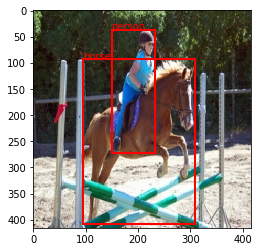

In [16]:
plot_dataset(datasets, 416, 416)

然後利用datasets來生成訓練用的資料，這邊因為我忘記論文中的模型類別數(80)與VOC這資料的類別數(20)不同，有點尷尬，所以這邊的模型還有相關函數的部份還是有做了些許的調整。模型的輸出就變成是M x N x N x (3 * (5 + 21))。

In [17]:
imgs, true_boxes, img_bboxes = generate_data_for_loss(datasets, 5, 42, 21)

一樣的，檢查確認維度是否在預期中

In [18]:
imgs.shape, true_boxes[0].shape, true_boxes[1].shape, true_boxes[2].shape, img_bboxes[0].shape, img_bboxes[1].shape, img_bboxes[2].shape, 

((5, 416, 416, 3),
 (5, 52, 52, 3, 26),
 (5, 26, 26, 3, 26),
 (5, 13, 13, 3, 26),
 (5, 42, 4),
 (5, 42, 4),
 (5, 42, 4))

有照片，有座標，有類別，該有的都有，

模型定義之後就可以來嚐試訓練，一樣的，我們先依序操作一次之後再將整個過程函數化包裝起來。

tf2.0是利用`with tf.GradientTape() as tape`來做為計算梯度的一個context，這部份可以參考簡單[粗暴tensorflow](https://tf.wiki/zh_hant/)，或是在下參考簡單粗暴tensorflow之後自己寫的[ipynb](https://github.com/shaoeChen/deeplearning/blob/master/tf2/MNIST_05_Keras(tf.keras.Model)_GradientTape.ipynb)

In [19]:
def convert_nan2zero(source_tensor):
    """把nan的tensor轉0
    
    如果用nan去跟其它的tensor加總的話會得到nan，因此需要做一個簡單的轉換
    """
    _cond = tf.math.is_nan(source_tensor) | tf.math.is_inf(source_tensor)
    return tf.where(_cond, 0, source_tensor)

In [20]:
with tf.GradientTape() as tape:
    model_output = model(imgs)
    
    # 設置loss的初始值
    giou_loss = conf_loss = prob_loss = 0.
    
    # 接著依各尺度分別計算加總loss
    # 記得我們的輸出分別是raw52, decoder52, raw26, decoder26, raw13, decoder13
    raw52, decoder52, raw26, decoder26, raw13, decoder13 = model_output
    try:
        loss_52 = yolo_loss(decoder52, raw52, true_boxes[0], img_bboxes[0], 21)
        loss_26 = yolo_loss(decoder26, raw26, true_boxes[1], img_bboxes[1], 21)
        loss_13 = yolo_loss(decoder13, raw13, true_boxes[2], img_bboxes[2], 21)
#         import pdb;pdb.set_trace()
    except:
        import pdb;pdb.set_trace()
    
    # loss回傳的順序為giou_loss, conf_loss, prob_loss
    giou_loss = convert_nan2zero(loss_52[0]) + convert_nan2zero(loss_26[0]) + convert_nan2zero(loss_13[0])
#     conf_loss = loss_52[1] + loss_26[1] + loss_13[1]
    conf_loss = convert_nan2zero(loss_52[1]) + convert_nan2zero(loss_26[1]) + convert_nan2zero(loss_13[1])
    prob_loss = convert_nan2zero(loss_52[2]) + convert_nan2zero(loss_26[2]) + convert_nan2zero(loss_13[2])
    
    total_loss = giou_loss + conf_loss + prob_loss
    
    # 計算梯度
    gradients = tape.gradient(total_loss, model.trainable_variables)
#     print(f'gradients: {gradients}')
    # 優化
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))    
    print(f'learning rate: {optimizer.lr.numpy()}, \
            giou_loss: {giou_loss}, include: {loss_52[0]}, {loss_26[0]}, {loss_13[0]}, \
            conf_loss: {conf_loss}, include: {loss_52[1]}, {loss_26[1]}, {loss_13[1]}, \
            prob_loss: {prob_loss}, include: {loss_52[2]}, {loss_26[2]}, {loss_13[2]}, \
            total_loss: {total_loss}')
    

learning rate: 9.999999747378752e-06,             giou_loss: 1.7750247716903687, include: 0.0, 0.821272075176239, 0.9537526965141296,             conf_loss: 1841.7274169921875, include: 1405.703125, 351.21771240234375, 84.80656433105469,             prob_loss: 26.200965881347656, include: 0.0, 8.733654975891113, 17.467309951782227,             total_loss: 1869.703369140625


上面來看似乎是沒有問題的，現在，我們就一樣的把這個函數化，準備迴圈訓練看看狀況。

In [21]:
import time
from tqdm import tqdm, trange

In [22]:
def training_step(model, training_data: tuple, epoch: int, loss_list: list, version=False):
    """訓練迭代
    
    model: training model for yolov3
    training_data: (imgs, true_boxes, img_bboxes)
        imgs: 照片
        true_boxes: M x 52 x 52 x ahchor_nums x (5 + class_nums)
                    M x 26 x 26 x ahchor_nums x (5 + class_nums)
                    M x 13 x 13 x ahchor_nums x (5 + class_nums)
                    
        img_bboxes: M x max_bboxes x 4, M x max_bboxes x 4, M x max_bboxes x 4
    epoch: 第幾次迭代
    version: 是否列印訓練訊息
    """        
#     import pdb;pdb.set_trace()
    imgs = training_data[0]
    true_boxes = training_data[1]
    img_bboxes = training_data[2]
    
    with tf.GradientTape() as tape:
        model_output = model(imgs)

        # 設置loss的初始值
        giou_loss = conf_loss = prob_loss = 0.

        # 接著依各尺度分別計算加總loss
        # 記得我們的輸出分別是raw52, decoder52, raw26, decoder26, raw13, decoder13
        raw52, decoder52, raw26, decoder26, raw13, decoder13 = model_output
#         import pdb;pdb.set_trace()
        try:
            loss_52 = yolo_loss(decoder52, raw52, true_boxes[0], img_bboxes[0], 21)
            loss_26 = yolo_loss(decoder26, raw26, true_boxes[1], img_bboxes[1], 21)
            loss_13 = yolo_loss(decoder13, raw13, true_boxes[2], img_bboxes[2], 21)    
        except:
            raise Exception('有毛！')

        # loss回傳的順序為giou_loss, conf_loss, prob_loss
        giou_loss = convert_nan2zero(loss_52[0]) + convert_nan2zero(loss_26[0]) + convert_nan2zero(loss_13[0])    
        conf_loss = convert_nan2zero(loss_52[1]) + convert_nan2zero(loss_26[1]) + convert_nan2zero(loss_13[1])
        prob_loss = convert_nan2zero(loss_52[2]) + convert_nan2zero(loss_26[2]) + convert_nan2zero(loss_13[2])
        total_loss = giou_loss + conf_loss + prob_loss
        loss_list.append((giou_loss, conf_loss, prob_loss, total_loss))
        # 計算梯度
        gradients = tape.gradient(total_loss, model.trainable_variables)
        # 優化
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))   
        if version is True and epoch % 100 == 0:
            print(f'learning rate: {optimizer.lr.numpy()}, \
                  giou_loss: {giou_loss}, include: {loss_52[0]}, {loss_26[0]}, {loss_13[0]}, \
                  conf_loss: {conf_loss}, include: {loss_52[1]}, {loss_26[1]}, {loss_13[1]}, \
                  prob_loss: {prob_loss}, include: {loss_52[2]}, {loss_26[2]}, {loss_13[2]}, \
                  total_loss: {total_loss}')
        
        if epoch % 10 == 0 and epoch != 0:
            
            print(f'{time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())}-> training epoch: {epoch}, total loss: {total_loss}')
            

In [23]:
model = tf.keras.Model(input_tensor, decoder_output_tensors)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)

在訓練過程中發現，這實在很多毛要注意，一個沒注意，模型的output就通通是nan，不是很好處理。

後來查看有發現到一個問題，模型output nan的問題來自於權重參數通通為nan，而權重參數通通為nan則是來自梯度為nan，再觀察梯度之後發現，梯度他老人家消失了。後來做了幾個模型調整：
1. conf loss做正規化處理，52x52的conf loss就除52，26x26的conf loss就除26，13x13的conf loss就除13
2. conv layer的初始定義修正
3. conv layer的正規化設定
4. 更小的學習效率(0.00001)
5. 0.00005 for 5000
6. 0.0001 for 5000
7. 0.0001 for 5000
8. 0.0001 for 5000(測試過8000次之後就梯度消失了，所以調整為5000，預計下次訓練降低學習效率)
9. 0.00001 for 4000(測試22000次，不過在4900之後就梯度爆炸了，因此調整為4000，然後再下降學習效率)
10. 0.000001 for 4500(推論出來的框已經感覺比較好了，至少類別的部份有正常一點)
11. 後續再訓練發現會出現梯度inf的問題，觀察是某些尺度的anchor box會有這種情況，所以加入函數轉換，當出現inf的時候就設置為0，避免訓練異常，並且取消掉conf loss的正規化處理

......

1. 基本上就是不斷的調整學習效率，不過在小到0.000001之後大概就會隨便都inf了情況出現，難以再調整，時間上的問題，就不再堅持一定要訓練好。不過我個人猜測，如果可以將darnket-53先做預訓練，然後再掛上yolo-layer，應該效果上可以比較好。這也許可以做為一個議題來測試才對。

2. 另外就是我突然想到，我拿COCO的anchor boxes prior來訓練VOC，呵呵...不知道是不是也有因為這樣而造成難以訓練的問題就是了。不管如何，能確定的是每次訓練之後我都去驗證框的情況，確實是有愈來愈好的趨勢就是。也許大方向是沒有錯的，剩下的就是訓練上的手法。

3. 後續有發現到，訓練過程中可能會有某個尺度的梯度為inf的問題，這造成加總之後造成的inf異常，所以加入函數調整，將inf轉為0，避免異常，繼續訓練
4. 訓練過程中發現，最終還是會發生inf、nan的問題，不過只要修正學習效率，跳脫那個障礙點之後，就可以成功繼續訓練
5. 修正學習效率的部份測試有發現，可以用大一點的學習效率，像是0.0001，然後少少的跑100個epochs，再回來小小的學習效率慢慢優化比較能成功

In [58]:
model = tf.saved_model.load('model/16')

In [62]:
optimizer.lr.assign(0.000001)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=1e-06>

In [65]:
epochs = 360
training_loss = []

for epoch in trange(epochs):
    # 取得一個資料批
    training_data = generate_data_for_loss(datasets, 5, 42, 21)
    training_step(model=model, training_data=training_data, epoch=epoch, loss_list=training_loss, version=True)    

  0%|          | 1/360 [00:09<57:28,  9.61s/it]

learning rate: 9.999999974752427e-07,                   giou_loss: 4.0187602043151855, include: 0.7980501055717468, 1.5114067792892456, 1.7093032598495483,                   conf_loss: 4.0127410888671875, include: 1.5307973623275757, 1.9631494283676147, 0.5187942385673523,                   prob_loss: 0.8718913197517395, include: 0.6201394200325012, 0.2420869618654251, 0.009664928540587425,                   total_loss: 8.903392791748047


  3%|▎         | 11/360 [01:45<55:53,  9.61s/it]

2022-12-29 07:33:17-> training epoch: 10, total loss: 10.992892265319824


  6%|▌         | 21/360 [03:21<54:11,  9.59s/it]

2022-12-29 07:34:53-> training epoch: 20, total loss: 6.2311110496521


  9%|▊         | 31/360 [04:56<52:35,  9.59s/it]

2022-12-29 07:36:29-> training epoch: 30, total loss: 8.46554946899414


 11%|█▏        | 41/360 [06:32<50:40,  9.53s/it]

2022-12-29 07:38:04-> training epoch: 40, total loss: 8.553262710571289


 14%|█▍        | 51/360 [08:07<48:59,  9.51s/it]

2022-12-29 07:39:39-> training epoch: 50, total loss: 8.778783798217773


 17%|█▋        | 61/360 [09:42<47:15,  9.48s/it]

2022-12-29 07:41:14-> training epoch: 60, total loss: 9.73682975769043


 20%|█▉        | 71/360 [11:18<45:58,  9.55s/it]

2022-12-29 07:42:50-> training epoch: 70, total loss: 12.751350402832031


 22%|██▎       | 81/360 [12:53<44:38,  9.60s/it]

2022-12-29 07:44:26-> training epoch: 80, total loss: 12.058745384216309


 25%|██▌       | 91/360 [14:29<42:46,  9.54s/it]

2022-12-29 07:46:02-> training epoch: 90, total loss: 3.324064254760742


 28%|██▊       | 101/360 [16:05<41:38,  9.65s/it]

learning rate: 9.999999974752427e-07,                   giou_loss: 10.409578323364258, include: 1.1889736652374268, 4.876439094543457, 4.344165802001953,                   conf_loss: 6.283970832824707, include: 1.953627347946167, 3.713380813598633, 0.6169626116752625,                   prob_loss: 2.932570219039917, include: 2.142193555831909, 0.790030837059021, 0.00034602973028086126,                   total_loss: 19.62611961364746
2022-12-29 07:47:37-> training epoch: 100, total loss: 19.62611961364746


 31%|███       | 111/360 [17:41<39:44,  9.58s/it]

2022-12-29 07:49:13-> training epoch: 110, total loss: 36.832862854003906


 34%|███▎      | 121/360 [19:16<37:51,  9.50s/it]

2022-12-29 07:50:49-> training epoch: 120, total loss: 3.6427769660949707


 36%|███▋      | 131/360 [20:53<36:41,  9.61s/it]

2022-12-29 07:52:25-> training epoch: 130, total loss: 15.665558815002441


 39%|███▉      | 141/360 [22:29<35:00,  9.59s/it]

2022-12-29 07:54:01-> training epoch: 140, total loss: 9.042171478271484


 42%|████▏     | 151/360 [24:03<33:09,  9.52s/it]

2022-12-29 07:55:36-> training epoch: 150, total loss: 9.056151390075684


 45%|████▍     | 161/360 [25:39<31:56,  9.63s/it]

2022-12-29 07:57:12-> training epoch: 160, total loss: 21.779727935791016


 48%|████▊     | 171/360 [27:15<30:01,  9.53s/it]

2022-12-29 07:58:47-> training epoch: 170, total loss: 15.012730598449707


 50%|█████     | 181/360 [28:51<28:28,  9.54s/it]

2022-12-29 08:00:23-> training epoch: 180, total loss: 19.065778732299805


 53%|█████▎    | 191/360 [30:27<27:01,  9.60s/it]

2022-12-29 08:01:59-> training epoch: 190, total loss: 12.001728057861328


 56%|█████▌    | 201/360 [32:02<25:29,  9.62s/it]

learning rate: 9.999999974752427e-07,                   giou_loss: 2.963930368423462, include: 0.0, 1.2037842273712158, 1.760146141052246,                   conf_loss: 2.466644048690796, include: 0.15666648745536804, 1.4150283336639404, 0.8949491381645203,                   prob_loss: 0.02288353443145752, include: 0.0, 0.013981804251670837, 0.008901730179786682,                   total_loss: 5.453457832336426
2022-12-29 08:03:35-> training epoch: 200, total loss: 5.453457832336426


 59%|█████▊    | 211/360 [33:39<24:10,  9.73s/it]

2022-12-29 08:05:12-> training epoch: 210, total loss: 9.616114616394043


 61%|██████▏   | 221/360 [35:15<22:24,  9.67s/it]

2022-12-29 08:06:48-> training epoch: 220, total loss: 31.64105796813965


 64%|██████▍   | 231/360 [36:51<20:28,  9.52s/it]

2022-12-29 08:08:23-> training epoch: 230, total loss: 9.54995346069336


 67%|██████▋   | 241/360 [38:27<18:59,  9.58s/it]

2022-12-29 08:09:59-> training epoch: 240, total loss: 1.2975845336914062


 70%|██████▉   | 251/360 [40:01<17:07,  9.42s/it]

2022-12-29 08:11:34-> training epoch: 250, total loss: 6.659411430358887


 72%|███████▎  | 261/360 [41:37<15:39,  9.49s/it]

2022-12-29 08:13:09-> training epoch: 260, total loss: 12.849123001098633


 75%|███████▌  | 271/360 [43:12<14:07,  9.52s/it]

2022-12-29 08:14:45-> training epoch: 270, total loss: 4.0756988525390625


 78%|███████▊  | 281/360 [44:49<12:42,  9.65s/it]

2022-12-29 08:16:21-> training epoch: 280, total loss: 6.254269599914551


 81%|████████  | 291/360 [46:25<10:59,  9.55s/it]

2022-12-29 08:17:57-> training epoch: 290, total loss: 6.75297737121582


 84%|████████▎ | 301/360 [48:01<09:31,  9.69s/it]

learning rate: 9.999999974752427e-07,                   giou_loss: 2.499314546585083, include: 0.0, 1.2569189071655273, 1.2423956394195557,                   conf_loss: 1.4445819854736328, include: 0.15637072920799255, 0.8937844038009644, 0.3944268822669983,                   prob_loss: 0.0014861095696687698, include: 0.0, 0.0008109532063826919, 0.0006751564214937389,                   total_loss: 3.945382595062256
2022-12-29 08:19:33-> training epoch: 300, total loss: 3.945382595062256


 86%|████████▋ | 311/360 [49:37<07:50,  9.60s/it]

2022-12-29 08:21:09-> training epoch: 310, total loss: 13.361509323120117


 89%|████████▉ | 321/360 [51:13<06:15,  9.62s/it]

2022-12-29 08:22:46-> training epoch: 320, total loss: 25.018814086914062


 92%|█████████▏| 331/360 [52:49<04:37,  9.58s/it]

2022-12-29 08:24:22-> training epoch: 330, total loss: 3.941410541534424


 95%|█████████▍| 341/360 [54:25<03:03,  9.66s/it]

2022-12-29 08:25:57-> training epoch: 340, total loss: 3.952955484390259


 98%|█████████▊| 351/360 [56:00<01:26,  9.59s/it]

2022-12-29 08:27:33-> training epoch: 350, total loss: 14.064325332641602


100%|██████████| 360/360 [57:26<00:00,  9.57s/it]


訓練好的模型為了避免意外發生，我們還是先保存再來測試，這部份請參考在下另外參考簡單粗暴tensorflow所寫的[MNIST_11_Keras_SavedModel.ipynb](https://github.com/shaoeChen/deeplearning/blob/master/tf2/MNIST_11_Keras_SavedModel.ipynb)

In [66]:
tf.saved_model.save(obj=model, export_dir='model/16')

INFO:tensorflow:Assets written to: model/16/assets


當然你也可以單純的保存權重，其實整個模型的核心就是權重最有價值..

In [ ]:
# model.save_weights("model/yolov3_weight7")

訓練完成，後續我們將繼續接續著應用，在關閉之後請務必確認相關的資料是否確實的保存下來，目前為止還不確定這次的訓練是否是成功的，不過有這邊的經驗，後續的調整應該就不是問題才是。

再後面也會再針對訓練成功究竟是調整那一個關鍵因素所造成的來做一個研究測試。